# [ This is Training Part ]
### 整體training架構參考 Prof. Hung-yi Lee.的課堂作業 
### 以下為其助教的github連結: https://github.com/ga642381/ML2021-Spring/blob/main/HW03/HW03.ipynb




# 1. 看GPU類型

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Dec  2 04:48:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    35W / 250W |   9089MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2. Download
## i. 原始資料集
## ii. 已經Preprocessing過的資料集
## iii. 已經train好的model 參數
## iv. Preprocessing code，這邊把function列出來但不執行
## 參考論文: Uysal, F., Hardalaç, F., Peker, O., Tolunay, T., & Tokgöz, N. (2021). Classification of Shoulder X-ray Images with Deep Learning Ensemble Models. Applied Sciences, 11(6), 2723. https://github.com/fatihuysal88/shoulder-c/blob/main/preprocess/preprocess.py
 


In [ ]:
!gdown --id '1XXbGy9AAODG6ijIZ-ufk6bj6zp4-Qq8b' --output bone.zip
!unzip bone.zip
!gdown --id '1r82X2JFoRHbLwu446oQdyDGpqEFB8ye8' --output new_train.zip
!unzip new_train.zip
!gdown --id '16fkaPXfI1j0wui01CNfjdbXl4pT-MQQb' --output new_test.zip
!unzip new_test.zip
!gdown --id '1BzedlECiMt4n0Uc_s-jjbMegzpwsEOGq' --output model.zip
!unzip model.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: new_train/train/HAND_6c0cfdd8a9_image3.png  
  inflating: new_train/train/WRIST_376e5aaece_image3.png  
  inflating: new_train/train/WRIST_5ff52d8c09_image3.png  
  inflating: new_train/train/HAND_459918b848_image2.png  
  inflating: new_train/train/WRIST_7072e1c40e_image1.png  
  inflating: new_train/train/WRIST_82d8a2c5d9_image1.png  
  inflating: new_train/train/HAND_1b55f00cd5_image2.png  
  inflating: new_train/train/WRIST_a96530a323_image3.png  
  inflating: new_train/train/HAND_d860443b89_image2.png  
  inflating: new_train/train/HAND_8b8f32bb79_image2.png  
  inflating: new_train/train/WRIST_26e82f5856_image3.png  
  inflating: new_train/train/WRIST_6933331bce_image2.png  
  inflating: new_train/train/WRIST_b8f10bf555_image3.png  
  inflating: new_train/train/HAND_ca4fea168f_image2.png  
  inflating: new_train/train/WRIST_dc40bbfc82_image1.png  
  inflating: new_train/train/WRIST_aa3cc8faa3_image3.png  
  inflating: new_train/train/FOREARM_e2c5

In [ ]:
# Preprocessing code
import numpy as np
import cv2
import os

def rotate_crop(img, rect):
    # rotate img
    angle = rect[2]
    rows, cols = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img_rot = cv2.warpAffine(img, M, (cols, rows))

    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0)
    box = cv2.boxPoints(rect)
    pts = np.int0(cv2.transform(np.array([box]), M))[0]
    pts[pts < 0] = 0

    # crop
    img_crop = img_rot[pts[1][1]:pts[0][1],pts[1][0]:pts[2][0]]
    return img_crop


def roı_clahe_pre_process(folder, new_folder):
    for filename in os.listdir(folder):
      img = cv2.imread(os.path.join(folder, filename),cv2.IMREAD_GRAYSCALE)  # read image from directory

      lower_black = np.array([0], dtype="uint16")
      upper_black = np.array([200], dtype="uint16")
      black_mask = cv2.inRange(img, lower_black, upper_black)
      img[np.where(black_mask == [0])] = [0]

      thresh = cv2.threshold(
          img, 30, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

      contours, _ = cv2.findContours(thresh, 1, 1)
      contours.sort(key=cv2.contourArea, reverse=True)

      min_area_rect = cv2.minAreaRect(contours[0][:, 0, :])

      cropped = rotate_crop(img, min_area_rect)
      if(cropped.size == 0):
          print(f'cropped size 0 {filename}')
          continue

      # determine clahe values
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

      cropped_clahe = clahe.apply(cropped)  # apply clahe transform on image

      # determine new path for save to image
      new_path = os.path.join(new_folder, filename)
      
      cv2.imwrite(new_path, cropped_clahe)  # save output to new paths

In [ ]:
# 新的train dataset
# folder="/content/train/train/"
# new_folder="/content/drive/MyDrive/111 NTU/DBME5028/midterm/new_train/train/"
# roı_clahe_pre_process(folder,new_folder)

# 新的test dataset
# folder="/content/test/test"
# new_folder="/content/drive/MyDrive/111 NTU/DBME5028/midterm/new_test/test"
# roı_clahe_pre_process(folder,new_folder)

# 3. Image EDA and split dataset with pandas library


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset ,Dataset
from torchvision.datasets import DatasetFolder
from tqdm.auto import tqdm
import os 
import pandas as pd
import matplotlib.pyplot as plt
import random
from torchsummary import summary

In [ ]:
# 固定random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  

    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
same_seeds(0)

In [ ]:
# augmentation
train_tfm = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(299),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 這邊還是用原始ImageNet的參數
    transforms.RandomAffine(degrees=30, translate=(0, 0.2), scale=(0.9, 1), shear=(6, 9))
])

test_tfm = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # 這邊還是用原始ImageNet的參數
])


In [ ]:
# 設定root path
train_root_path = './new_train/' # '/content/train/'
test_root_path = './new_test/'#'/content/test/'
y_label_path = './train.csv'
model_root_path = './model/'
pandas_y = pd.read_csv(y_label_path,index_col='id').fillna(-1)

## 把train, valid, test label, unlabel的標籤資料分開，以利dataset建立
### i. train_label_y
### ii. valid_label_y
### iii. train_unlabel_y
### iv. test_unlabel_y

In [ ]:
# 將影像中的檔名，包含有不同部位的資料做成one hot encoding當作model判斷的輔助資料
def add_part_one_hot_encoding(y):
  hand_list = []
  forearm_list = []
  wrist_list = []

  for i in y.index.tolist():
    part = i.split('_')[0]
    if  part == 'HAND':
      hand_list.append(1)
      forearm_list.append(0)
      wrist_list.append(0)
      
    elif part == 'FOREARM':
      hand_list.append(0)
      forearm_list.append(1)
      wrist_list.append(0)

    elif part == 'WRIST':
      hand_list.append(0)
      forearm_list.append(0)
      wrist_list.append(1)

    else:
      print(f'another part:{i}')

  column_names=['label','HAND','FOREARM','WRIST']
  
  y = y.reindex(columns = column_names)
  y[column_names[0]] = y['label']
  y[column_names[1]] = hand_list
  y[column_names[2]] = forearm_list
  y[column_names[3]] = wrist_list

  return y

In [ ]:
pandas_y = add_part_one_hot_encoding(pandas_y.copy())

In [ ]:
train_id = os.listdir(train_root_path+'train')

In [ ]:
train_content = []
for i in train_id:
  y_label_id = i.split('_')[0]+'_'+i.split('_')[1]
  train_content.append([i]+pandas_y.loc[y_label_id].tolist())

In [ ]:
train_folder_y = pd.DataFrame(train_content, columns = ['id','label','HAND','FOREARM','WRIST'])
train_folder_y.set_index('id' , inplace=True)

In [ ]:
patient_id_list = []
for i in train_folder_y.index:
  patient_id_list.append(i.split('_')[0]+'_'+i.split('_')[1])
train_folder_y=train_folder_y.assign(patient_id=patient_id_list)

In [ ]:
train_folder_label_y = train_folder_y[train_folder_y['label'] != -1]
train_unlabel_y = train_folder_y[train_folder_y['label'] == -1]

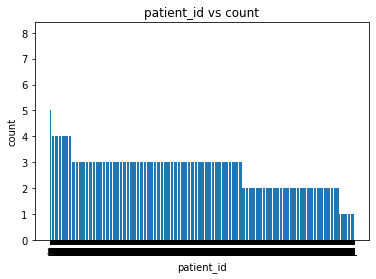

In [ ]:
plt.bar(train_folder_label_y['patient_id'].value_counts().index.tolist(), train_folder_label_y['patient_id'].value_counts().tolist())
plt.xticks(train_folder_label_y['patient_id'].value_counts().index.tolist(), train_folder_label_y['patient_id'].value_counts().tolist())
plt.xlabel('patient_id')
plt.ylabel('count')
plt.title('patient_id vs count')
plt.show()

In [ ]:
all_label_patient_id = list(set(train_folder_label_y['patient_id'].tolist()))
valid_label_patient_id = random.sample(all_label_patient_id, 500)
train_label_patient_id = list(set(all_label_patient_id)-set(valid_label_patient_id))

In [ ]:
train_label_y = train_folder_label_y[~train_folder_label_y['patient_id'].isin(valid_label_patient_id)]
valid_label_y = train_folder_label_y[train_folder_label_y['patient_id'].isin(valid_label_patient_id)]

In [ ]:
test_id = os.listdir(test_root_path+'test')
test_label = [ -1 for i in range(0,len(test_id))]
test_unlabel_y = pd.DataFrame(list(zip(test_id,test_label)), columns = ['id','label'])
test_unlabel_y.set_index('id' , inplace=True)
test_unlabel_y = add_part_one_hot_encoding(test_unlabel_y.copy())

In [ ]:
patient_id_list = []
for i in test_unlabel_y.index:
  patient_id_list.append(i.split('_')[0]+'_'+i.split('_')[1])
test_unlabel_y=test_unlabel_y.assign(patient_id=patient_id_list)

## 將only hand的資料集單獨抽出來訓練 

In [ ]:
name_list = []
for i in train_label_y.index:
  if 'HAND' in i:
    name_list.append(i)

In [ ]:
train_label_y.loc[name_list]['label'].value_counts()

0.0    2048
1.0     519
Name: label, dtype: int64

In [ ]:
train_label_y = train_label_y.loc[name_list]

In [ ]:
name_list = []
for i in valid_label_y.index:
  if 'HAND' in i:
    name_list.append(i)

In [ ]:
valid_label_y.loc[name_list]['label'].value_counts()

0.0    454
1.0    141
Name: label, dtype: int64

In [ ]:
valid_label_y = valid_label_y.loc[name_list]

In [ ]:
name_list = []
for i in train_unlabel_y.index:
  if 'HAND' in i:
    name_list.append(i)

In [ ]:
train_unlabel_y = train_unlabel_y.loc[name_list]

# 4. 半監督式學習 teacher_student training

## 建立customDataset的格式，主要是在pandas列表上做操作

In [ ]:
class customDataset(Dataset):
    def __init__(self,pd_y_label,root_dir,mode,transform=None):
        self.pd_y_label = pd_y_label
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        
    def __getitem__(self, index):
        img_name = self.pd_y_label.index[index]
        img_path = os.path.join(self.root_dir,self.mode,img_name)
        img = Image.open(img_path)
        y_label = self.pd_y_label.loc[img_name].tolist()[0]
        aux_x = self.pd_y_label.loc[img_name].tolist()[1:-1]

        if self.transform:
          img = self.transform(img)
        return img,aux_x,y_label
        
    def __len__(self):
        return len(self.pd_y_label)

## batch_size、dataset 及 dataloader

In [ ]:
batch_size = 64

train_set = customDataset(train_label_y, train_root_path, mode='train',transform=train_tfm)
valid_set = customDataset(valid_label_y, train_root_path, mode='train',transform=test_tfm)
unlabel_set = customDataset(train_unlabel_y, train_root_path, mode='train',transform=train_tfm)
unlabel_test_set = customDataset(test_unlabel_y, test_root_path, mode='test',transform=train_tfm)
test_set = customDataset(test_unlabel_y, test_root_path, mode='test',transform=test_tfm)
 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
torch_pretrained_model = torchvision.models.inception_v3(pretrained=True, init_weights=True, aux_logits=False)
# torch_pretrained_model = efficientnet_b3(pretrained=True) # 2560

In [ ]:
# 看model架構
torch_pretrained_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

## 建立自己的model，主要更換後面的fc layer

In [ ]:
class Classifier(nn.Module):
    def __init__(self,torch_pretrained_model):
        super(Classifier, self).__init__()
        
        self.torch_pretrained_model = torch_pretrained_model
        self.torch_pretrained_model.dropout = nn.Identity()
        self.torch_pretrained_model.fc = nn.Identity()
        self.classifier = nn.Sequential(
                            nn.BatchNorm1d(2048+3),
                            nn.Dropout(p=0.25,inplace=True),
                            nn.Linear(in_features=2048+3, out_features=512, bias=True),
                            nn.LeakyReLU(0.1,inplace=True),
                            nn.BatchNorm1d(512),
                            nn.Dropout(p=0.5,inplace=True),
                            nn.Linear(512, 1, bias=True),
                            nn.Sigmoid()
                        )
    def forward(self, x, aux_x):
        x = self.torch_pretrained_model(x)
        # print(aux_x.shape,x.shape)
        x = torch.cat((aux_x,x),1)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

## 將unlabeled data(train及test)進行標註

In [ ]:
def get_pseudo_labels(dataset, model, mode, upthreshold=0.9, downthreshold=0.1):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()

    resIndice = []
    resValue = []
    batch_index = 0

    for batch in tqdm(data_loader):
        imgs, aux_x, labels = batch
        aux_x = torch.cat((torch.reshape(aux_x[0], (len(aux_x[0]),1)),torch.reshape(aux_x[1], (len(aux_x[1]),1)),torch.reshape(aux_x[2], (len(aux_x[2]),1))),1).float()
        with torch.no_grad():
            logits = model(imgs.to(device),aux_x.to(device))
        for logits_index in range(len(logits)):
          if logits[logits_index].item()>upthreshold or logits[logits_index].item()<downthreshold:
            index = batch_index*batch_size + logits_index
            resIndice.append(index)
            resValue.append(round(logits[logits_index].item()))
        batch_index = batch_index + 1

    if mode == 'train':
      res_unlabel_y = train_unlabel_y.iloc[resIndice]
      root_path = train_root_path
    else: 
      res_unlabel_y = test_unlabel_y.iloc[resIndice]
      root_path = test_root_path
    
    res_unlabel_y.loc[:,'label']= resValue
    model.train()
    res_dataset = customDataset(res_unlabel_y, root_path, mode=mode,transform=train_tfm)

    return res_dataset

## focal loss : 這邊直接使用其他人的實現方式來自pytorch論壇 
* https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/14
* gamma=2, alpha=0.25 用論文建議的參數

In [ ]:
def focal_loss(bce_loss, targets, gamma=2, alpha=0.25):
    p_t = torch.exp(-bce_loss)
    alpha_tensor = (1 - alpha) + targets * (2 * alpha - 1)
    f_loss = alpha_tensor * (1 - p_t) ** gamma * bce_loss
    return f_loss.mean()

## Training Part and Testing Part : teacher_student 每經過一次就Inference一個submission csv

In [ ]:
num_student = 12
for i in range(0,num_student+1):
    print("Now student step:", i)
    # ------------------------------------ 進行 pseudo label的標註 ---------------------------------------------------------
    pseudo_set = []
    pseudo_test_set = []
    if i != 0:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        # print(device)
        PATH = model_root_path+"best_model_hand" + str(i-1) + ".pt"
        model = Classifier(torch_pretrained_model).to(device)
        model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))
        model.device = device

        pseudo_set = get_pseudo_labels(unlabel_set, model,mode='train')
        pseudo_test_set = get_pseudo_labels(unlabel_test_set, model,mode='test')
        print(f'Now pseudo_set\'s size: {len(pseudo_set)+len(pseudo_test_set)}')

    
    concat_dataset = []
    if i <= 5: # 5以下僅用train unlabeled dataset； 5以上用train和test unlabeled dataset
        concat_dataset = ConcatDataset([train_set, pseudo_set])
    else:
        concat_dataset = ConcatDataset([train_set, pseudo_set, pseudo_test_set])
        
    # ------------------------------------ initial parameter and model ------------------------------------------------------------------------

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = Classifier(torch_pretrained_model).to(device)
    model.device = device
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)

    n_epochs = 100
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs) # 將Tmax設為最大n_epochs，這樣learning rate會cosine式下降

    # Whether to do semi-supervised learning.
    do_semi = True
    best_score = -1.0
    pseudo_set = []

    # ------------------------------------- training ----------------------------------------------------------------------------------------------
    for epoch in range(n_epochs):
        if do_semi:
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
        model.train()

        train_loss = []
        train_accs = []

        for batch in tqdm(train_loader):

            
            imgs, aux_x, labels = batch
            aux_x = torch.cat((torch.reshape(aux_x[0], (len(aux_x[0]),1)),torch.reshape(aux_x[1], (len(aux_x[1]),1)),torch.reshape(aux_x[2], (len(aux_x[2]),1))),1).float()
            logits = model(imgs.to(device),aux_x.to(device))
            loss = focal_loss(criterion(logits, labels.reshape(-1,1).float().to(device)),labels.reshape(-1,1).float().to(device))
            optimizer.zero_grad()
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            acc = (torch.round(logits) == labels.to(device)).float().mean()
            train_loss.append(loss.item())
            train_accs.append(acc)

        scheduler.step()

        # train的acc和loss在每個batch上的平均
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ------------------------------------------------------- Validation -----------------------------------------------------------------
        model.eval()

        valid_loss = []
        valid_accs = []

        for batch in tqdm(valid_loader):
            imgs, aux_x, labels = batch
            aux_x = torch.cat((torch.reshape(aux_x[0], (len(aux_x[0]),1)),torch.reshape(aux_x[1], (len(aux_x[1]),1)),torch.reshape(aux_x[2], (len(aux_x[2]),1))),1).float()

            with torch.no_grad():
              logits = model(imgs.to(device),aux_x.to(device))

            loss = focal_loss(criterion(logits, labels.reshape(-1,1).float().to(device)),labels.reshape(-1,1).float().to(device))
            acc = (torch.round(logits) == labels.to(device)).float().mean()
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)
        if valid_acc > best_score:
            best_score = valid_acc
            PATH = model_root_path+"best_model_hand" + str(i) + ".pt" # Save 每次訓練之後最好acc的model
            torch.save(model.state_dict(), PATH)

        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, history_acc = {best_score:.5f}")
        print(f"{epoch}th epoch lr:{optimizer.param_groups[0]['lr']}")
    
    # ----------------------------------------- Save 每次訓練之後的model-----------------------------------------
    PATH = model_root_path+"last_model_hand" + str(i) + ".pt"
    torch.save(model.state_dict(), PATH)
    
    # ----------------------------------------- Inference(Testing) 用每次最好的model -------------------------------------------------------
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    PATH = model_root_path+"best_model_hand" + str(i) + ".pt"
    
    model = Classifier(torch_pretrained_model).to(device)

    model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))
    model.device = device

    model.eval()

    predictions = []
    for batch in tqdm(test_loader):
        imgs, aux_x, labels = batch
        aux_x = torch.cat((torch.reshape(aux_x[0], (len(aux_x[0]),1)),torch.reshape(aux_x[1], (len(aux_x[1]),1)),torch.reshape(aux_x[2], (len(aux_x[2]),1))),1).float()

        with torch.no_grad():
          logits = model(imgs.to(device),aux_x.to(device))
        predictions = predictions + logits.cpu().detach().numpy().reshape(-1).tolist()

    with open("predict_hand" + str(i) + ".csv", "w") as f:
        f.write("id,label\n")
        test_index = test_unlabel_y.index.tolist()
        for i, pred in enumerate(predictions):
          f.write(f"{test_index[i]},{pred}\n")

# Only Testing Part : 僅Inference一個submission csv 並 將submission.csv的各張照片ensembling起來，得到patient id 的0,1值(這粒的submission csv預設使用'predict_hand12.csv')

In [ ]:
# ensembeling images to patient id 
import pandas as pd 
kaggle = pd.read_csv('sample_submission.csv',index_col='id')
# incpetionv3
incv3 = pd.read_csv('predict_hand12.csv',index_col='id') # 這裡預設上面inference出來的檔案名稱

probs_list = []
for i in kaggle.index.tolist() : 
    probs = 0
    count = 0
    for j in incv3.index.tolist():
        
        if i in j:
            probs = probs + incv3.loc[j]['label']
            count = count + 1
    probs_list.append(round(probs/count))
kaggle.loc[:,'label'] = probs_list 
kaggle.to_csv('kaggle_incv3_01.csv') # 最後結果名稱

# Reference
[1] 整體training架構參考 Prof. Hung-yi Lee.的課堂作業
以下為其助教的github連結: https://github.com/ga642381/ML2021-Spring/blob/main/HW03/HW03.ipynb

[2] Preprocessing code，這邊把function列出來但不執行
參考論文: Uysal, F., Hardalaç, F., Peker, O., Tolunay, T., & Tokgöz, N. (2021). Classification of Shoulder X-ray Images with Deep Learning Ensemble Models. Applied Sciences, 11(6), 2723. https://github.com/fatihuysal88/shoulder-c/blob/main/preprocess/preprocess.py

[3] focal loss : 這邊直接使用其他人的實現方式來自pytorch論壇
https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/14
gamma=2, alpha=0.25 用論文建議的參數
